Number of records labeled in round 1: 33260
Number of records not labeled in round 1: 966740


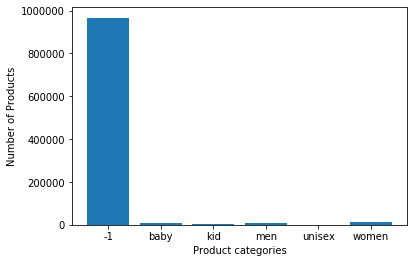

-1        966740
women      13876
men        10158
baby        6972
kid         1436
unisex       818
Name: class, dtype: int64


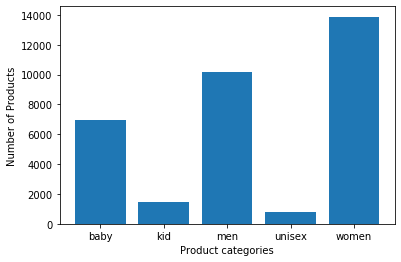

-1        966740
women      13876
men        10158
baby        6972
kid         1436
unisex       818
Name: class, dtype: int64


In [2]:

from IPython import get_ipython
get_ipython().magic('reset -sf') 

import nltk
import pandas as pd
import numpy as np
import re
import codecs
import gc
from nltk.corpus import wordnet
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pivottablejs import pivot_ui
import random 
from nltk.probability import FreqDist
import pickle
gc.collect()
    

# Helper Functions

# Number of records to be written in the file for manual examination
sample_test_size=20
# which feature to focus for labeling 'all_tokens', 
imp_feature='product_type'
# number of records to process
max_record=1000000

def plot_class_distribution (data_frame, groupby_feature,class_name, starting_index=0):
    grouped  = data_frame.groupby([class_name]) 
    values=grouped[groupby_feature].agg(np.size)[starting_index:]  
    labels =  values.index.tolist()  
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()
    print(data_frame[class_name].value_counts())

#Lemmatize Normalization
def normalize (tokens):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(token,pos=get_wordnet_pos(token)) for token in tokens]

#clean up  tokenized  data
def standardize_tokens (tokens):
    return [token.lower() for token in tokens]

#map NLTK’s POS tags
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)




dbfile = open('../data/processed/processed-1milliom', 'rb')      
df= pickle.load(dbfile) 
dbfile.close() 
df.shape

df=df[0:max_record]

df.head()

# Round 1: Label  records based on the occurance of the keywords

# our categories and their related words
classes=['unisex', 'men', 'women', 'kid', 'baby']
manNet=['man','men', 'male', 'gentleman', 'gent','masculine',' manlike', ' mannish']
womanNet=['woman', 'women', 'lady', 'female' 'ladies', 'girl','feminine','unmacho','metrosexual' ]
babyNet= ['baby','toddler','infant', 'babe', 'bambino', 'infant', 'neonate', 'newborn']
kidNet=['kid','child', 'children', 'child', 'youth', 'joni','schoolchild', 'schoolgirl', 'schoolkid','junior']
unisexNet=['unisex','androgynous', 'genderless', 'unisexual']
all_Nets_list= [manNet,womanNet,babyNet,kidNet,unisexNet ]

##  Frequency of the categories and their synonyms in the product information 


#count occurence of keyword in the list
def countFreq (product_info, keywordList):
    total_count =0
    for item in product_info:
      total_count += keywordList.count(item)
    return total_count


df['unisex'] = df[imp_feature].apply(countFreq,keywordList=unisexNet)   
df['men'] = df[imp_feature].apply(countFreq,keywordList=manNet) 
df['women'] = df[imp_feature].apply(countFreq,keywordList=womanNet)  
df['baby'] = df[imp_feature].apply(countFreq,keywordList=babyNet)  
df['kid'] = df[imp_feature].apply(countFreq,keywordList=kidNet)        

df['class']=  '-1'



## Choose the label with the highest occurance of the keyword 

# choose the label with the highest occurance of the keyword 
def findLabel(row): 
        maxCount=max(row)
        if maxCount> 0:
            maxLabel= row[row == maxCount].index[0] 
        else:
            maxLabel='-1'
        return maxLabel
    
df.loc[:,'class']=df.loc[:,classes].apply(findLabel,axis=1) 


#  Find records labeled in  round 1

#keep trackes of record labeled in this round
labeled_data_index_r1=df[df['class']!= '-1'].index.to_list()

print("Number of records labeled in round 1:", len(labeled_data_index_r1))
print("Number of records not labeled in round 1:",df.shape[0]-len(labeled_data_index_r1))

## The distribution of classes including Nan

plot_class_distribution (df, 'product_type','class', starting_index=0)

## The distribution of classes excluding Nan

plot_class_distribution (df, 'product_type','class', starting_index=1)

##  Choose some randoms record to check the labeling in this round



#labeled_data=df[df['class']!= '-1'].copy()
#unlabeled_data_index=df.index.difference(labeled_data.index)

random_records=random.sample(labeled_data_index_r1, k=sample_test_size) 
test=df.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round1.csv", index=True)


# Export Labeled Data

#df['all_text']= df['all_tokens'].apply(lambda x: " ".join(x))
df.to_csv("../data/labeled/labeled_dataV1-1milliom.csv", index=True)
 

dbfile = open('../data/labeled/labeled_dataV1-1million', 'wb')      
pickle.dump(df, dbfile) 
dbfile.close() 
  
random_records=random.sample(labeled_data_index_r1, k=sample_test_size) 
test=df.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round1-1million.csv", index=True)